# Plotting With SparkMagic on Hops

To run large scale computations in a hops cluster from Jupyter we use sparkmagic, a livy REST server, and the pyspark kernel. 

The fact that the default computation on a cluster is distributed over several machines makes it a little different to do things such as plotting compared to when running code locally. 

This notebook illustrates how you can combine plotting and large-scale computations on a Hops cluster in a single notebook.

In [84]:
# When pyspark kernel is started we get a Spark session automatically created for us
spark

##  Check which "magic" functions are avilable from sparkmagic

In [85]:
%%help

Magic,Example,Explanation
info,%%info,Outputs session information for the current Livy endpoint.
cleanup,%%cleanup -f,"Deletes all sessions for the current Livy endpoint, including this notebook's session. The force flag is mandatory."
delete,%%delete -f -s 0,Deletes a session by number for the current Livy endpoint. Cannot delete this kernel's session.
logs,%%logs,Outputs the current session's Livy logs.
configure,"%%configure -f{""executorMemory"": ""1000M"", ""executorCores"": 4}",Configure the session creation parameters. The force flag is mandatory if a session has already been created and the session will be dropped and recreated.Look at Livy's POST /sessions Request Body for a list of valid parameters. Parameters must be passed in as a JSON string.
spark,%%spark -o dfdf = spark.read.parquet('...,"Executes spark commands. Parameters: -o VAR_NAME: The Spark dataframe of name VAR_NAME will be available in the %%local Python context as a Pandas dataframe with the same name. -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe that will be pulled from Livy to Jupyter. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
sql,%%sql -o tables -qSHOW TABLES,"Executes a SQL query against the variable sqlContext (Spark v1.x) or spark (Spark v2.x). Parameters: -o VAR_NAME: The result of the SQL query will be available in the %%local Python context as a Pandas dataframe. -q: The magic will return None instead of the dataframe (no visualization). -m, -n, -r are the same as the %%spark parameters above."
local,%%locala = 1,All the code in subsequent lines will be executed locally. Code must be valid Python code.


## Load a CSV file in Spark

The pokemon csv file is available [here](https://www.kaggle.com/abcsds/pokemon)

In [86]:
df = spark.read.format("csv").option("header", "true").load("hdfs:///Projects/Visualization_Demo/Pokemon/Pokemon.csv")

In [87]:
df.count()

800

In [88]:
df.show(5)

+---+--------------------+------+------+-----+---+------+-------+-------+-------+-----+----------+---------+
|  #|                Name|Type 1|Type 2|Total| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|
+---+--------------------+------+------+-----+---+------+-------+-------+-------+-----+----------+---------+
|  1|           Bulbasaur| Grass|Poison|  318| 45|    49|     49|     65|     65|   45|         1|    False|
|  2|             Ivysaur| Grass|Poison|  405| 60|    62|     63|     80|     80|   60|         1|    False|
|  3|            Venusaur| Grass|Poison|  525| 80|    82|     83|    100|    100|   80|         1|    False|
|  3|VenusaurMega Venu...| Grass|Poison|  625| 80|   100|    123|    122|    120|   80|         1|    False|
|  4|          Charmander|  Fire|  null|  309| 39|    52|     43|     60|     50|   65|         1|    False|
+---+--------------------+------+------+-----+---+------+-------+-------+-------+-----+----------+---------+
only showing top 5 

## Name the Spark DataFrame to Be Able to Use SQL

In [89]:
df.createOrReplaceTempView("pokemons")

## Use SparkMagic to Collect the Spark Dataframe as a Pandas Dataframe Locally

This command will send the dataset from the cluster to the server where Jupyter is running and convert it into a pandas dataframe. This is only suitable for smaller datasets. A common practice is to run spark jobs to process a large dataset and shrink it before plotting.

In [90]:
%%sql -c sql -o python_df --maxrows 10
SELECT * FROM pokemons

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oSFRNTCh2YWx1ZT11J1R5cGU6JyksIEJ1dHRvbihkZXNjcmlwdGlvbj11J1RhYmxlJywgbGF5b3V0PUxheW91dCh3aWR0aD11JzcwcHgnKSzigKY=


Output()

## The Pandas DataFrame is now Available in %%local mode

In [92]:
%%local
python_df.head()

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oSFRNTCh2YWx1ZT11J1R5cGU6JyksIEJ1dHRvbihkZXNjcmlwdGlvbj11J1RhYmxlJywgbGF5b3V0PUxheW91dCh3aWR0aD11JzcwcHgnKSzigKY=


Output()

In [93]:
%%local
python_df["Name"].values

array([u'Bulbasaur', u'Ivysaur', u'Venusaur', u'VenusaurMega Venusaur',
       u'Charmander', u'Charmeleon', u'Charizard',
       u'CharizardMega Charizard X', u'CharizardMega Charizard Y',
       u'Squirtle'], dtype=object)

In [ ]:
%%bash
pip install --user matplotlib
pip install --user seaborn

## Local Plotting with MatplotLib and Seaborn

After the Data Have Been Loaded Locally as a pandas dataframe, it can get plotted on the Jupyter server. By using the magic "%%local" at the top of a cell, the code in the cell will be executed locally on the Jupyter server, rather than remotely with Livy on the Spark cluster. Once the pandas dataframe is available locally it can be plotted with libraries such as matplotlib and seaborn

In [94]:
%%local
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

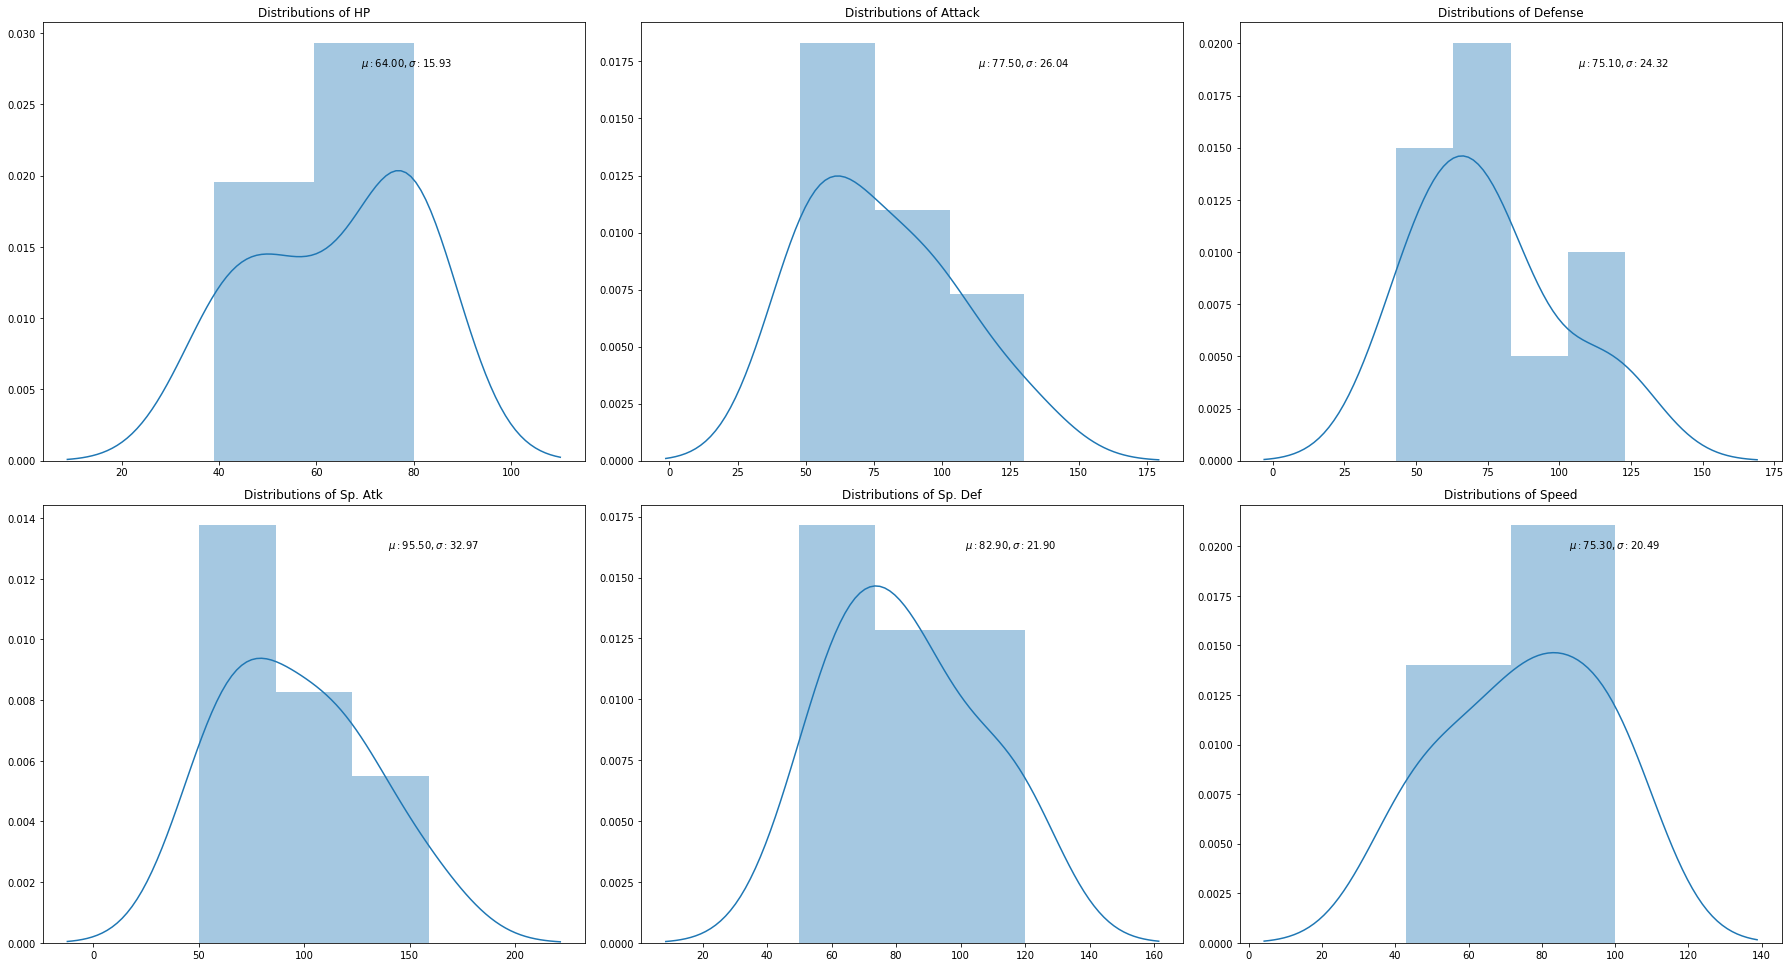

In [95]:
%%local
stats = python_df.columns[5:11]
plt.figure(figsize=(25, 20))

for ii, stat in enumerate(stats):
    title = "Distributions of {stat}".format(
        stat = stat
    )
    plt.subplot(3, 3, ii+1)
    plt.title(title)
    stats = np.array(map(lambda x: int(x), python_df[stat].values))
    sns.distplot(stats)
    x = plt.gca().get_xlim()[1] * .6
    y = plt.gca().get_ylim()[1] * .9
    plt.text(x, y, '$\mu: {mu: .2f}, \sigma: {sigma: .2f}$'.format(mu = stats.mean(), sigma=stats.std()))
    
    
plt.tight_layout()
plt.show()

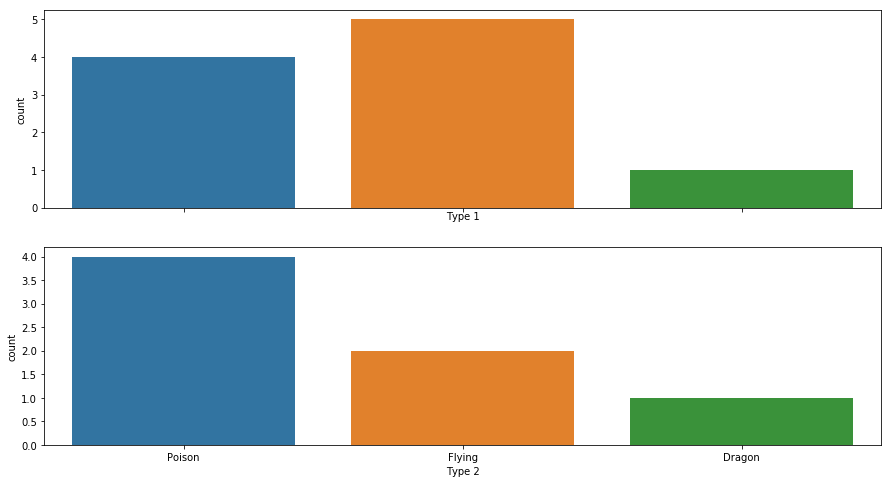

In [96]:
%%local
#view the nuumber of pokemons for Type 1 and Type 2 using one plot
f, (ax1,ax2) = plt.subplots(2,1,figsize=(15, 8),sharex=True)

sns.countplot('Type 1',data=python_df,ax=ax1)
sns.countplot('Type 2',data=python_df,ax=ax2)

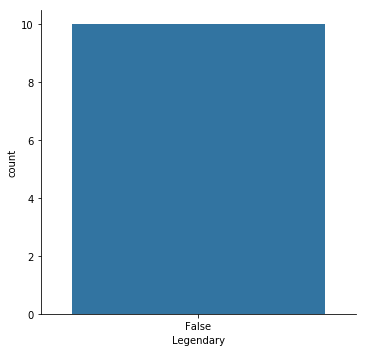

In [97]:
%%local
sns.factorplot(x='Legendary',kind='count',data=python_df,height=5,aspect=1)